### Import Required Libraries
---

In [67]:
import os
import random
import time
import platform
import requests

import numpy as np
import matplotlib.pyplot as plt
import cv2
import seaborn as sns
from tqdm import tqdm
from sklearn import metrics
from PIL import Image

import torch
import torch.nn.functional as F
from torch import nn, optim

from torch.optim import lr_scheduler

from torchvision import transforms, models, datasets, utils

### Work in Colab or Local

In [2]:
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

# Debug
print(IN_COLAB)
if IN_COLAB:
  model_path = '/content/drive/My Drive/exp-fer_p3_01/'
  from google.colab import drive
  drive.mount('/content/drive')

False


### Model Architectures
---

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('\nDevice: {0}'.format(device))


Device: cpu


### Model Architecture Definition
---

In [5]:
ARCH_NAME = 'resnet18'

if ARCH_NAME == 'simplenet':
    # Simple net
    model = Net(3, 5)

elif ARCH_NAME == 'alexnet':
    # Pretrainned
    model = models.alexnet(weights='AlexNet_Weights.DEFAULT')
    ### model = models.alexnet(weights='AlexNet_Weights.IMAGENET1K_V1')
    # Changes the number of neurons in the output layer.
    num_ftrs = model.classifier[6].in_features
    model.classifier[6] = nn.Linear(num_ftrs, 5)

elif ARCH_NAME == 'resnet18':
    model = models.resnet18(pretrained=True).to(device)

    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, 5).to(device)

# elif ARCH_NAME == 'mobilenetv2':
#     model = CustomMobileNetv2(output_size=5).to(device)

# Include more architectures...
# ---
### elif ARCH_NAME == ...

c:\Users\Samuel Oliveira\Desktop\CS\computer-vision-deep-learning-notebooks\.venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Samuel Oliveira\Desktop\CS\computer-vision-deep-learning-notebooks\.venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\Samuel Oliveira/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:01<00:00, 30.8MB/s]


### Load Model From Path
---

In [20]:
path = '../model/exp-fer_p3_01/'
model_path = os.path.join(path, f"fer-classification-{ARCH_NAME}-model.pth")
model_path

'../model/exp-fer_p3_01/fer-classification-resnet18-model.pth'

In [22]:
model.to(device)

model.load_state_dict(torch.load(model_path, map_location='cpu'))

<All keys matched successfully>

### Model Parameters
---

In [23]:
# Calculate and print the total number of trainable parameters
total_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\nTotal trainable parameters: {total_trainable_params}")


Total trainable parameters: 11179077


### Define data transform

In [24]:
data_transform = transforms.Compose([
    # It is necessary to resize the image to match the network's input size.
    transforms.Resize(230),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    # Mean and standard deviation of ImageNet
    # These are required as we will use a model pre-trained on ImageNet.
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

### Create Test Loader for Model Inference

In [49]:
if IN_COLAB:
  ds_path = '/content/drive/My Drive/Data/faces-emotion-recognition/faces/'
else:
  ds_path = '../data/'
ds_path

'../data/'

In [50]:
batch_size = 64
test_set = datasets.ImageFolder(ds_path+'test', transform=data_transform)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=True, num_workers=2)

In [52]:
classes = test_set.classes
classes

['angry', 'fear', 'happy', 'neutral', 'sad']

### GPU Pre-Heating

In [53]:
# Pré-aquecimento da GPU (só se tiver CUDA disponível)
if device.type == "cuda":
    with torch.no_grad():
        dummy = torch.randn(1, 3, 224, 224, device=device)
        _ = model(dummy)

### Model Test
---

In [54]:
labels_true = []
labels_pred = []

model.eval()

with torch.no_grad():
  for images, labels in tqdm(test_loader):
    images, labels = images.to(device), labels.to(device)

    outputs = model(images)

    # pred = outputs.data.max(1, keepdim=True)[1]

    labels_pred.extend(outputs.cpu().numpy())
    labels_true.extend(labels.cpu().numpy())

labels_pred = np.array(labels_pred)
labels_true = np.array(labels_true)

100%|██████████| 50/50 [01:23<00:00,  1.67s/it]


### Confusion Matrix
---

In [55]:
# Get the index of max probabilities
labels_pred_argmax = np.argmax(labels_pred, axis=1)
print("True Labels: ", labels_true[:10])
print("True Labels: ", labels_pred_argmax[:10])

True Labels:  [2 2 2 2 1 4 1 1 0 2]
True Labels:  [2 2 2 2 1 1 4 1 0 2]


In [56]:
cm = metrics.confusion_matrix(labels_true, labels_pred_argmax)
print("Confusion Matrix")
print(cm)

Confusion Matrix
[[266  43   9  38  62]
 [ 70 433  19  78 123]
 [ 15  16 770  61  19]
 [ 26  29  43 328  93]
 [ 57  79  27  94 352]]


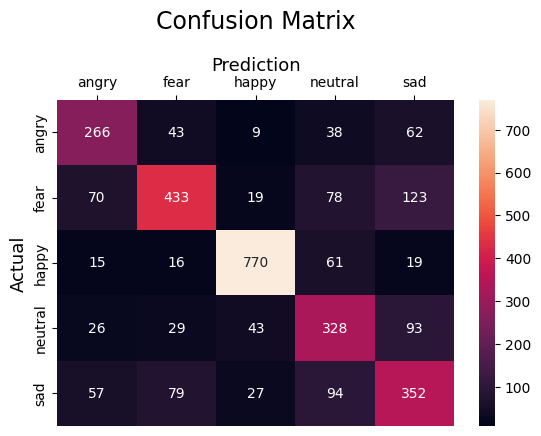

In [57]:
sns.heatmap(cm,
            annot=True,
            fmt='g',
            xticklabels=classes,
            yticklabels=classes)
plt.ylabel('Actual', fontsize=13)
plt.title('Confusion Matrix', fontsize=17, pad=20)
plt.gca().xaxis.set_label_position('top')
plt.xlabel('Prediction', fontsize=13)
plt.gca().xaxis.tick_top()

plt.gca().figure.subplots_adjust(bottom=0.2)
plt.show()

### Classification Report
---

In [58]:
cr = metrics.classification_report(y_true=labels_true, y_pred=labels_pred_argmax, target_names=classes)
print("Classification Report")
print(cr)

Classification Report
              precision    recall  f1-score   support

       angry       0.61      0.64      0.62       418
        fear       0.72      0.60      0.65       723
       happy       0.89      0.87      0.88       881
     neutral       0.55      0.63      0.59       519
         sad       0.54      0.58      0.56       609

    accuracy                           0.68      3150
   macro avg       0.66      0.66      0.66      3150
weighted avg       0.69      0.68      0.68      3150



### Image Inference
---

#### Load model haarcascade detection

In [ ]:
face_cascade = cv2.CascadeClassifier("../model/haarcascade_frontalface_default.xml")

In [136]:
def face_detect(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    face_img = image.copy()
    face_rect = face_cascade.detectMultiScale(face_img, scaleFactor=1.2, minNeighbors=5)

    for (x, y, w, h) in face_rect:
        face_image_detect = face_img[y:y+h, x:x+w]
        cv2.rectangle(face_img, (x, y), (x + w, y + h), (255, 255, 255), 10)
        
    return face_img, face_image_detect

In [137]:
def plot_images(image, face_detect_image, face_image):
    # Create a figure and a 2x2 grid of subplots
    fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(12, 10))
    
    axs[0].imshow(image, cmap='gray')
    axs[0].set_title('Original Image')
    
    axs[1].imshow(face_detect_image, cmap='gray')
    axs[1].set_title('Detect Face')
    
    axs[2].imshow(face_image, cmap='gray')
    axs[2].set_title('Face image')
    
    # Adjust layout to prevent overlapping titles/labels
    plt.tight_layout()
    plt.show()

#### Load image from URL

In [161]:
# Load your image
image_url = "https://previews.123rf.com/images/bowie15/bowie151401/bowie15140100071/39843011-angry-face-man.jpg"
# image = Image.open(image_path).convert("RGB") # Ensure RGB format
image = Image.open(requests.get(image_url, stream=True).raw)

# Converter para numpy
image = np.array(image)
image_face_detect, image_face = face_detect(image)

#### Plot Original Image, Detected Image and Face Image

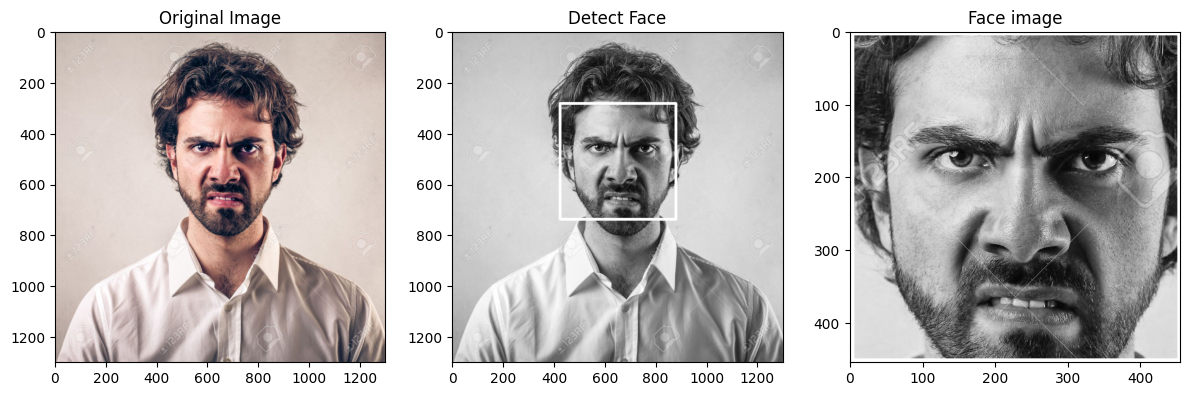

In [162]:
plot_images(image, image_face_detect, image_face)

#### Data transform for model input

In [163]:
# transform image from numpy array to Pil image
# convert image to rgb (224, 224, 3)
image_face = Image.fromarray(image_face).convert("RGB")

# Apply the transform
transformed_image = data_transform(image_face)

# Add a batch dimension if your model expects batched input
# (e.g., for a single image, shape will be [1, C, H, W])
input_tensor = transformed_image.unsqueeze(0)
input_tensor = input_tensor.to(device)
print("input tensor shape: ", input_tensor.shape)

# Define classes mapping
class_mapping = [
    "angry",
    "fear",
    "happy",
    "neutral",
    "sad"
]

input tensor shape:  torch.Size([1, 3, 224, 224])


#### Model Inference with no gradients

In [164]:
model.eval()
with torch.no_grad():
    output = model(input_tensor)
    predicted_index = torch.argmax(output, dim=1).item()

    print(output)
print("Predicted class:", class_mapping[predicted_index])

tensor([[  7.3159,  -6.4986, -18.1373,  -3.3350,  -0.3432]])
Predicted class: angry
